# Quantitative Risk Analysis for finance 

- Here we will develop a Parametric VAR (Value at Risk) model. 

# Parametric VAR model 

- Value at Risk (VaR) is the regulatory measurement for assessing market risk. It reports the maximum likely loss on a portfolio for a given probability defined as x% confidence level over N days. VaR is vital in market risk management and control. Also regulatory and economic capital computation is based on VaR results. Although VaR measure is objective and intuitive, it doesn’t capture tail risk. There are three commonly used methodologies to calculate VaR – parametric, historical simulation and Monte Carlo simulation.

- The above can be thought of as the probability of a specified financial loss occurring at or within a specified point in time.  

- Here, we will develop a parametric VAR model.

In [2]:
# import libraries as required
# note: "import yfinance as yf" is required as the data on Yahoo is now encrypted, 
# so we need yfinance API to fetch data 
import pandas as pd 
import numpy as np 
import datetime as dt 
from pandas_datareader import data as pdr
import yfinance as yf    
import matplotlib.pyplot as plt
import scipy as sp
from scipy.optimize import minimize

# override recursion limit(s)
import sys
sys.setrecursionlimit(10000)

In [3]:
# firstly we override the default panda data reader with a yahoo module to fetch data 
yf.pdr_override()

# The Efficient Frontier - Part 1 
# Expected returns based on a given portfolio

- To create a VAR analysis model, we will create the 'efficient frontier', i.e., plot returns as a function of risk such that an optimised portfolio can be created. 

- The efficient frontier is a 2nd order polynomial showing the set of optimal portfolios that offer the highest expected return for a defined level of risk or the lowest risk for a given level of expected return. 
- Portfolios that lie below the efficient frontier are sub-optimal because they do not provide enough return for the level of risk. Portfolios that cluster to the right of the efficient frontier are sub-optimal because they have a higher level of risk for the defined rate of return.

- Hence, the efficient frontier calculates the highest return of a portfolio for a specified level or risk. This is portfolio optimisation.  

In [4]:
# here, we define the stock tickers which will be used to fetch live data from yahoo finance via API  
# I have chosen 3 at random, placed in a list and specified stock weightings, as below... 
tickers = ['UBER','MCD','SBUX']  

stock_name = [stock_name for stock_name in tickers] 

weights = np.array([0.3,0.3,0.4])

print(stock_name)


['UBER', 'MCD', 'SBUX']


In [5]:
# we now define the end date and the start dates which we will use to grab data,
# here I will use the current time and previous 365 days, as below...

end_date = dt.datetime.now()
start_date = end_date - dt.timedelta(days=365)


In [6]:
# Having specified the tickets, end date, and start date, 
# we use the yahoo API and create a data frame of stock data using pandas...   


# Hence, we define such a function to pull stock data 
def get_data(stock_name,start_date,end_date):
    
    # this will fetch all data and store in panda data frame 
    stock_data = pdr.get_data_yahoo(stock_name,start=start_date,end=end_date)  
    
    # we only want the close data, so specify this here  
    stock_data = stock_data['Close']    
    
    # we want to get the stock return(s) 
    stock_returns = stock_data.pct_change()
    
    # we also want the mean and covariance of the returns as we will use these in our calculations
    stock_returns_mean = stock_returns.mean()
    stock_returns_covMatrix = stock_returns.cov()
    
    return stock_returns_mean, stock_returns_covMatrix  


In [7]:
# we call the above function... 
get_data(stock_name,start_date,end_date)


[*********************100%***********************]  3 of 3 completed


(MCD     0.000665
 SBUX    0.000926
 UBER    0.002976
 dtype: float64,
            MCD      SBUX      UBER
 MCD   0.000103  0.000081  0.000020
 SBUX  0.000081  0.000301  0.000183
 UBER  0.000020  0.000183  0.001045)

- Note: portfolio variance = $w^{T} \ \Sigma \ w $

- where, w = weights, T = transpose (both are matrices)

In [8]:
# next, we calculate the portfolio performance, i.e., calculate the return and standard deviation of
# a given portfolio with given stock weightings...  

# hence, we define such a function
def portfolio_performance(weights, stock_returns_mean, stock_returns_covMatrix):
    
    # we sum the mean returns and multiply by the weighting of each stock in the portfolio, 
    # note: this is daily, so we also need to multiply by the number of trading days in a year
    portfolio_returns = np.sum(stock_returns_mean*weights)*252
    
    # we also need the standard deviations 
    portfolio_std_dev = np.sqrt( np.dot(weights.T, np.dot(stock_returns_covMatrix,weights))) * np.sqrt(252)
    
    return portfolio_returns, portfolio_std_dev 

In [9]:
# putting all the above together...

# we have chosen out stocks (and tickers), the start and end time, and the stock weightings in portfolio, 
# now, we calculate the stock return of each stock and the covariance matrix,
# we then use this, in combination with our weightings to calculate portfolio performance, 
# this is shown in terms of return and an uncertainty, i.e., standard deviation 

# calculate the mean and covariacne 
stock_returns_mean,stock_returns_covMatrix = get_data(stock_name,start_date,end_date)

# calculate the stock performace  
portfolio_returns, portfolio_std_dev = portfolio_performance(weights, stock_returns_mean, stock_returns_covMatrix)

# lets print results as a percentage
print('Expected return : ', portfolio_returns*100, '+/-', portfolio_std_dev*100)

[*********************100%***********************]  3 of 3 completed
Expected return :  42.028054817318484 +/- 25.927274105428904


# Putting it together...
- Having defined the required functions, as above, we can run the above code using a few lines, as below... 
- Just define the ticker, weightings, time, and then run code... 
- The expected return will be printed. 

In [10]:
tickers = ['AAPL','MSFT','GS']
weights = np.array([0.3,0.3,0.4])
stock_name = [stock_name for stock_name in tickers] 
end_date = dt.datetime.now()
start_date = end_date - dt.timedelta(days=365)
stock_returns_mean,stock_returns_covMatrix = get_data(stock_name,start_date,end_date) 
portfolio_returns, portfolio_std_dev = portfolio_performance(weights, stock_returns_mean, stock_returns_covMatrix)
print('Expected return : ', portfolio_returns*100, '+/-', portfolio_std_dev*100)

[*********************100%***********************]  3 of 3 completed
Expected return :  23.700029325292007 +/- 24.970666734724496


# The Efficient Frontier - Part 2 
# The Sharpe Ratio - (Maximum sharp ratio)

- Having created a portfolio and calculated the return, we now need to modify the portfolio such that we can optimise it. 
- To do this, we will first calculate the Sharpe ratio.

- The Sharpe ratio compares the return of an investment with its risk. Economist William F. Sharpe proposed the Sharpe ratio in 1966 as an outgrowth of his work on the capital asset pricing model (CAPM), calling it the reward-to-variability ratio. Sharpe won the Nobel Prize in economics for his work on CAPM in 1990.

- The Sharpe ratio's numerator is the difference over time between realized, or expected, returns and a benchmark such as the risk-free rate of return or the performance of a particular investment category. Its denominator is the standard deviation of returns over the same period of time, a measure of volatility and risk.
- We will therefore get the stock weights for a maximum sharpe ratio for a given portfolio, i.e., the ratio of stock allocation in a portfolio which gives the best return with a specified risk, (returns divided by the std. dev.) 

In [11]:
# Here, we define a function which accepts the weight of a stock, the return of a stock, 
# the covariance of a stock, and an optional parameter of the risk free rate as parameters, 
# and returns a negative sharpe ratio (more on the -ve value later)
def get_neagtive_sharpe_ratio(weights, stock_returns_mean, stock_returns_covMatrix, risk_free_rate =0):
    
    # calculate portfolio returns and std. dev. 
    portfolio_returns, portfolio_std_dev = portfolio_performance(weights, stock_returns_mean, stock_returns_covMatrix)
    
    # use portfolio returns, risk free rate, and portfolio std. dev. to calculate a negative value for sharpe ration 
    neg_sharp_ratio_value = -(portfolio_returns-risk_free_rate)/portfolio_std_dev
    
    return neg_sharp_ratio_value


In [12]:
# Having defined the sharpe ratio, we now want a function which finds the maximum sharpe ratio, 
# note: as we flipped the sharpe ratio, hence making it negative, minimising this will maximise the 
# sharpe ratio. We do this as it is easier to find a minimum of a function using scipy, 
# see docs...
# https://docs.scipy.org/doc/scipy/tutorial/optimize.html

# Here, we define a function will changes the weights of the stocks in the portfolio to get the maximum sharpe ratio 
def get_max_sharpe_ratio(stock_returns_mean, stock_returns_covMatrix, risk_free_rate =0,constraint_conditions=(0,1)):
    
    # first get number of stocks... 
    number_of_stocks = len(stock_returns_mean)
    
    # pass arguments to scipy optimisation function
    args_to_be_passed = (stock_returns_mean, stock_returns_covMatrix, risk_free_rate)

    # also need constraints which need to be tuple 
    constraints = ({'type':'eq','fun':lambda x: np.sum(x)-1})
    
    # also need bounds 
    bound = constraint_conditions
    bounds = tuple(bound for stock in range(number_of_stocks))
    
    # notes on scipy optimisation...
    # first argument is what (function) we are trying to optimise over, this will be the sharp ratio, 
    # next is the changing parameter, i.e., the weighting. 
    # We also need an initial guess for initialisation, 
    # we then have the function arguments, 
    # also, we have the method of optimisation, we will choose Sequential Least Squares Programming optimizer, 
    # and we also choose boundry conditions, and constraints 
    result = sp.optimize.minimize(get_neagtive_sharpe_ratio, number_of_stocks*[1./number_of_stocks],
                                 args = args_to_be_passed, method='SLSQP',bounds=bounds,constraints=constraints) 
    
    return result

In [13]:
# print 
print('This is the best reward vs. risk calculation...\n')

# we call the above function for optimised (max) Sharpe ratio...
result_output = get_max_sharpe_ratio(stock_returns_mean, stock_returns_covMatrix)

# and print info...
max_sharpe_ratio, stock_allocation = result_output['fun'], result_output['x']

print('best Sharpe ratio is:\n\n',-max_sharpe_ratio,'\n\nwith a % stock allocation of:\n\n',
      np.round(stock_allocation*100, 2), 
     '\n\nin:',list((stock_returns_mean.head()).index))

This is the best reward vs. risk calculation...

best Sharpe ratio is:

 1.0883556746597047 

with a % stock allocation of:

 [77.15  0.   22.85] 

in: ['AAPL', 'GS', 'MSFT']


# The Efficient Frontier - Part 3 

# Optimising the sharp ratio for a portfolio with minimum portfolio variance (risk) 

In [14]:
# we need to define a function which takes a portfolio weight and returns the risk (variance)
# to do that we reuse the portfolio_performance function and just get one parameter from it, as below... 

def portfolio_variance(weights, stock_returns_mean, stock_returns_covMatrix):

    # this will therefore call the original function and return only 1 parameter
    return portfolio_performance(weights, stock_returns_mean, stock_returns_covMatrix)[1] 

In [15]:
# now we build the optimisation function, and minimise portfolio variance by altering stock weights or allocation. 
# This function is similar to the maximise sharpe ratio formula,
# i.e., we are using an optimisation function...

# note: the code is copied from max sharpe ratio, as above, see for details,
# however, the function passed for optimised via scipy is different...

def get_minimum_portfolio_variance(stock_returns_mean, stock_returns_covMatrix,constraint_conditions=(0,1)):
    
    number_of_stocks = len(stock_returns_mean)

    args_to_be_passed = (stock_returns_mean, stock_returns_covMatrix)

    constraints = ({'type':'eq','fun':lambda x: np.sum(x)-1})
  
    bound = constraint_conditions
    bounds = tuple(bound for stock in range(number_of_stocks))
    
    # note the change in input function (first argument)
    result = sp.optimize.minimize(portfolio_variance, number_of_stocks*[1./number_of_stocks],
                                 args = args_to_be_passed, method='SLSQP',bounds=bounds,constraints=constraints) 
    
    return result

In [16]:
# this is the minimum variacne portfolio
print('this is the minimum variacne portfolio...\n')

# we call the above function to determine the minimum variance portfolio...
variance_result_output = get_minimum_portfolio_variance(stock_returns_mean, stock_returns_covMatrix)

# and print info...
min_variance, min_var_stock_allocation = variance_result_output['fun'], variance_result_output['x']

print('Sharpe ratio for minimum variance portfolio is:\n\n',min_variance,'\n\nwith a % stock allocation of:\n\n',
      np.round(min_var_stock_allocation*100, 2), 
     '\n\nin:',list((stock_returns_mean.head()).index))

this is the minimum variacne portfolio...

Sharpe ratio for minimum variance portfolio is:

 0.23535423361739263 

with a % stock allocation of:

 [28.19 56.54 15.28] 

in: ['AAPL', 'GS', 'MSFT']


# The Efficient Frontier - Part 4  
# We will now obtain results for a portfolio with the maximum sharpe ratio, i.e., the highest level of returns for a given level of volatility, and the returns for the minimum variance portfolio, i.e., the portfolio with the minimum variancne and associated portfolio weightings...

- We will read in the mean returns and the covariant matrix of the selected stocks in the portfolio, and output the maximum sharpe ratio and the minimum volatility. 
- This gives us the highest level of return for a specified level of risk, and the return for a minimum variance (risk) portfolio. 
- These can then be used to create the effective frontier plot. 

In [17]:
def results_for_efficient_frontier(stock_returns_mean, stock_returns_covMatrix, 
                                   risk_free_rate =0,constraint_conditions=(0,1)):
    
    # get sharpe ratio and stock allocation 
    results_max_SR = get_max_sharpe_ratio(stock_returns_mean, stock_returns_covMatrix)
    
    # then get returns based on stock allocation 
    max_SR_returns, max_SR_std_dev = portfolio_performance(results_max_SR['x'], stock_returns_mean, stock_returns_covMatrix)
    
    # lets reformat the data 
    max_SR_returns, max_SR_std_dev = np.round(max_SR_returns*100,2), np.round(max_SR_std_dev*100,2)
    
    # create a panda data frame to output results in a nice format 
    max_SR_portfolio = pd.DataFrame(results_max_SR['x'], index=stock_returns_mean.index, columns=["weighting"])
    
    # lets edit the data format - (turn to percentage and round) 
    max_SR_portfolio.weighting = [round(i*100,2) for i in max_SR_portfolio.weighting]
    
    
    # ----- 
    # repeating the above code for the minimum variance portfolio
    results_min_var = get_minimum_portfolio_variance(stock_returns_mean, stock_returns_covMatrix)

    min_var_returns, min_var_std_dev = portfolio_performance(results_min_var['x'], stock_returns_mean, stock_returns_covMatrix)

    min_var_returns, min_var_std_dev = np.round(min_var_returns*100,2), np.round(min_var_std_dev*100,2)
    
    min_var_portfolio = pd.DataFrame(results_min_var['x'], index=stock_returns_mean.index, columns=["weighting"])

    min_var_portfolio.weighting = [round(i*100,2) for i in min_var_portfolio.weighting]
    
    return max_SR_returns, max_SR_std_dev, max_SR_portfolio, min_var_returns, min_var_std_dev, min_var_portfolio    

In [18]:
# and print info...
results_for_efficient_frontier(stock_returns_mean, stock_returns_covMatrix)

(31.08,
 28.55,
       weighting
 AAPL      77.15
 GS         0.00
 MSFT      22.85,
 18.06,
 23.54,
       weighting
 AAPL      28.19
 GS        56.54
 MSFT      15.28)

# The Efficient Frontier - Part 5 

- We now iterate through a list of target returns, and for each return we calculate the portfolio variance - we can then plot volatility as a function of return.

- To do this, we loop the results (results_for_efficient_frontier) function, and add a new parameter. 

- This parameter is the target return. 

In [19]:
# for each return target, we will optimise the portfolio for minimum variance

# create a portfolio returns function, this is similar to the portfolio_variance function 
# which was previously created, so we take that function and edit it such that it returns the portfolio returns, 
# instead of the portfolio variance, see *** below 
def portfolio_returns(weights, stock_returns_mean, stock_returns_covMatrix):
    return portfolio_performance(weights, stock_returns_mean, stock_returns_covMatrix)[0] # note 0 instead of 1 


# create function here, which can be iterated easily - similar to minimum portfolio variance formula  
def iterate_results_for_efficient_frontier(stock_returns_mean, stock_returns_covMatrix, 
                                   portfolio_target,constraint_conditions=(0,1)):
    
    # numbers and args same as before 
    number_of_stocks = len(stock_returns_mean) 

    args_to_be_passed = (stock_returns_mean, stock_returns_covMatrix)
    
    # constraint placed on portfolio returns, otherwise same as before 
    constraints = ({'type':'eq','fun':lambda x: portfolio_returns(x,stock_returns_mean, 
                                                                  stock_returns_covMatrix)-portfolio_target},
                   {'type':'eq','fun':lambda x: np.sum(x)-1})
    
    # bounds same as before 
    bound = constraint_conditions
    bounds = tuple(bound for stock in range(number_of_stocks))
    
    # iterator same as before 
    iterate_results = sp.optimize.minimize(portfolio_variance, number_of_stocks*[1./number_of_stocks], 
                                           args = args_to_be_passed, method='SLSQP',
                                           bounds=bounds,constraints=constraints)
    
    return iterate_results

- And now we iterate...

In [21]:
# function is copied from section 4 - and we add the iterator function 

def results_for_efficient_frontier_2(stock_returns_mean, stock_returns_covMatrix, 
                                   risk_free_rate =0,constraint_conditions=(0,1)):
    
    # -----
    # max sharpe ratio portfolio
    # get sharpe ratio and stock allocation 
    results_max_SR = get_max_sharpe_ratio(stock_returns_mean, stock_returns_covMatrix)
    
    # then get returns based on stock allocation 
    max_SR_returns, max_SR_std_dev = portfolio_performance(results_max_SR['x'], stock_returns_mean, stock_returns_covMatrix)
        
    # create a panda data frame to output results in a nice format 
    max_SR_portfolio = pd.DataFrame(results_max_SR['x'], index=stock_returns_mean.index, columns=["weighting"])
    
    # lets edit the data format - (turn to percentage and round) 
    max_SR_portfolio.weighting = [round(i*100,2) for i in max_SR_portfolio.weighting]
    
    
    # ----- 
    # minimum variance portfolio
    # repeating the above code for the minimum variance portfolio
    results_min_var = get_minimum_portfolio_variance(stock_returns_mean, stock_returns_covMatrix)

    min_var_returns, min_var_std_dev = portfolio_performance(results_min_var['x'], stock_returns_mean, stock_returns_covMatrix)
    
    min_var_portfolio = pd.DataFrame(results_min_var['x'], index=stock_returns_mean.index, columns=["weighting"])

    min_var_portfolio.weighting = [round(i*100,2) for i in min_var_portfolio.weighting]
    
    
    # -----
    # the efficient frontier
    # note: can add this here, it uses results from both the max sharpe ratio and minimum variance portfoli
    #
    # note:
    # state here... the number of data points needed for the efficient frontier plot, 
    # or the number of iterations, which are between the minimum variance and max sharpe ratio portfolios, 
    # i.e., how many data points you want in your plot...
    return_volitility = []
    target_returns = np.linspace(min_var_returns,max_SR_returns,50)
    for target in target_returns:
        return_volitility.append(iterate_results_for_efficient_frontier(stock_returns_mean, stock_returns_covMatrix,target)['fun'])

        
    # lets reformat the data 
    max_SR_returns, max_SR_std_dev = np.round(max_SR_returns*100,2), np.round(max_SR_std_dev*100,2)
    min_var_returns, min_var_std_dev = np.round(min_var_returns*100,2), np.round(min_var_std_dev*100,2)
    
    #target_returns = target_returns *100
    #return_volitility = return_volitility * 100
    
    
    return max_SR_returns, max_SR_std_dev, max_SR_portfolio,min_var_returns, min_var_std_dev, min_var_portfolio, target_returns, return_volitility

# Finally, create the efficient frontier plot...

Text(0, 0.5, 'Portfolio return (%)')

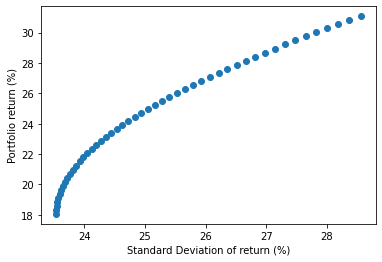

In [23]:
# print info and plot the efficient frontier 
resultsssss = results_for_efficient_frontier_2(stock_returns_mean, stock_returns_covMatrix)

plt.scatter(np.array(resultsssss[7])*100,resultsssss[6]*100)
plt.xlabel('Standard Deviation of return (%)')
plt.ylabel('Portfolio return (%)')